## 导入库并配置环境

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from pyhanlp import *
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator
import numpy as np
from PIL import Image
import collections
from tqdm.notebook import tqdm_notebook as tqdm
import cv2

%matplotlib inline
font = {'family' : 'SimHei',
         'weight' : 'bold',
         'size'   : '16'}
plt.rc('font', **font)               # 设置字体的更多属性,
plt.rc('axes', unicode_minus=False)  # 解决坐标轴负数的负号显示问题

## 导入数据集

In [157]:
df_military = pd.read_excel("./今日头条新闻数据/今日头条-军事.xlsx")
df_car = pd.read_excel("./今日头条新闻数据/今日头条-汽车.xlsx")
df_fashion = pd.read_excel("./今日头条新闻数据/今日头条-时尚.xlsx")
df_sports = pd.read_excel("./今日头条新闻数据/今日头条-体育.xlsx")
df_game = pd.read_excel("./今日头条新闻数据/今日头条-游戏.xlsx")
df_recreation = pd.read_excel("./今日头条新闻数据/今日头条-娱乐.xlsx")

## 处理dataframe得到文本

In [5]:
# 定义函数
def get_textdata(df):
    textdata = ' '.join(df["内容"].values.tolist())
    return textdata

In [6]:
# 得到文本数据
text_military = get_textdata(df_military)
text_car = get_textdata(df_car)
text_fashion = get_textdata(df_fashion)
text_sports = get_textdata(df_sports)
text_game = get_textdata(df_game)
text_recreation = get_textdata(df_recreation)

In [122]:
# 设置停词
file = open('./stopwords.txt',encoding='utf-8')
stopwords = [string.replace('\n','') for string in file.readlines()]
stopwords.append(' ') 

### 仅使用文本得到词云图
仅以car和game绘制

In [73]:
# 定义函数
def wordcloudplot_fromtext(textdata,mask,stopwords):
    wc = WordCloud(font_path='C:\\Windows\\Fonts\\msyh.ttc',
                   background_color='white',   #可以选择black或white
                   margin=5, width=mask.shape[0], height=mask.shape[1], # 长宽度控制清晰程度
                   stopwords=stopwords,
                   mask=mask,
                   contour_width=10, 
                   contour_color='steelblue',
                   scale=5) # 扩大尺寸提升清晰度,时间的损耗会大大增加，N^2
    wordcloud = wc.generate(textdata)
    plt.figure(figsize=(16,8))
    plt.axis("off")
    if mask.ndim != 2:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    else:
        plt.imshow(wordcloud)
    plt.show()

    image_colors = ImageColorGenerator(mask_car)
    wordcloud.recolor(color_func=image_colors)
函数的这部分是使得图片词的颜色与原图接近，参考官方文档的 [example-Image-colored wordcloud](http://amueller.github.io/word_cloud/auto_examples/colored.html?highlight=color_func)

**注**:不知道为什么，使用cv2读图片得到的颜色和图片颜色不一致，plt没尝试

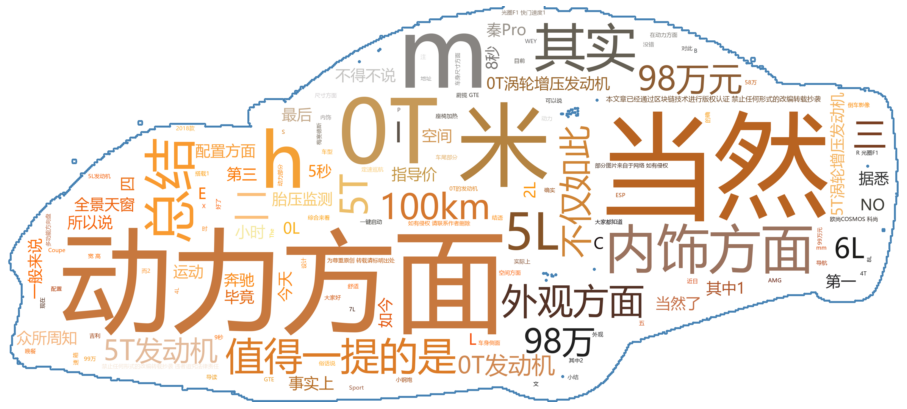

In [74]:
# car
mask_car = np.array(Image.open("./Image/car.png"))
wordcloudplot_fromtext(text_car,mask_car,stopwords)

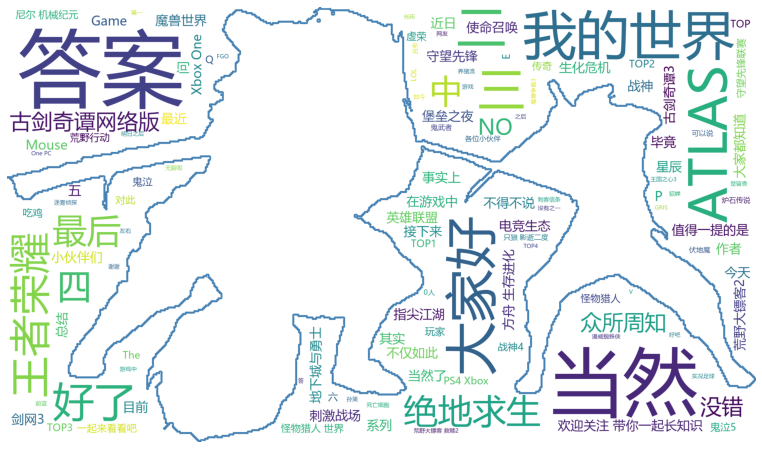

In [80]:
# game
mask_game = (plt.imread('./Image/who am i.png')[:,:,-1]*255).astype(int) # 最后还是没得到理想效果
wordcloudplot_fromtext(text_game,mask_game,stopwords)

这里应该是我制作的png图片有问题，但不知道为什么会出问题。

In [40]:
# 边缘处应为透明的点
print('plt:',plt.imread('./Image/who am i.png')[20][20])
print('cv2:',cv2.imread('./Image/who am i.png')[20][20])
print('Image',np.array(Image.open('./Image/who am i.png'))[20][20])

plt: [0. 0. 0. 0.]
cv2: [0 0 0]
Image [0 0 0 0]


In [48]:
# 中间偏左为黑色部分
print('plt:',plt.imread('./Image/who am i.png')[200][150])
print('cv2:',cv2.imread('./Image/who am i.png')[200][150])
print('Image',np.array(Image.open('./Image/who am i.png'))[200][150])

plt: [0. 0. 0. 1.]
cv2: [0 0 0]
Image [  0   0   0 255]


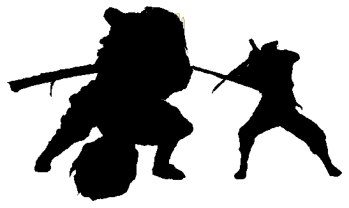

In [47]:
# 显示的效果
plt.imshow(plt.imread('./Image/who am i.png'))
plt.axis(False)
plt.show()

### 通过HanLP统计词频

In [87]:
# 进行处理
data_car = HanLP.segment(text_car)
data_game = HanLP.segment(text_game)

In [88]:
# 定义词频函数
def TF(data):
    count = collections.Counter()
    for term in tqdm(data):
        count[term.word] += 1
    return count

count_car = TF(data_car)
count_game = TF(data_game)

In [145]:
# 按词频降序
dict_car = dict(sorted(count_car.items(), key = lambda x:x[1], reverse = True))
dict_game = dict(sorted(count_game.items(), key = lambda x:x[1], reverse = True))

In [146]:
# 过滤停用词
def word_filter(word_dict): # 有瑕疵，不知道怎么处理word in stopwords的情况
    new_dict = {None if word in stopwords else word:count for word,count in word_dict.items()}
    try:
        new_dict.pop(None)
    except:
        pass
    return new_dict

dict_car = word_filter(dict_car)
dict_game = word_filter(dict_game)

### 从词频字典里绘制词云图

In [151]:
# 定义函数
def wordcloudplot_fromdict(freq_dict,mask,stopwords):
    wordcloud = WordCloud(font_path='C:\\Windows\\Fonts\\msyh.ttc',
                          background_color="white",   #可以选择black或white
                          margin=5, #width=0, height=800, # 有mask时会忽略width和height，参加文档
                          stopwords=stopwords,
                          mask=mask,
                          contour_width=10, 
                          contour_color='steelblue',
                          scale=5)
    wordcloud = wordcloud.generate_from_frequencies(freq_dict)
    plt.figure(figsize=(16,8))
    plt.axis("off")
    if mask.ndim != 2:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
    else:
        plt.imshow(wordcloud)
    plt.show()

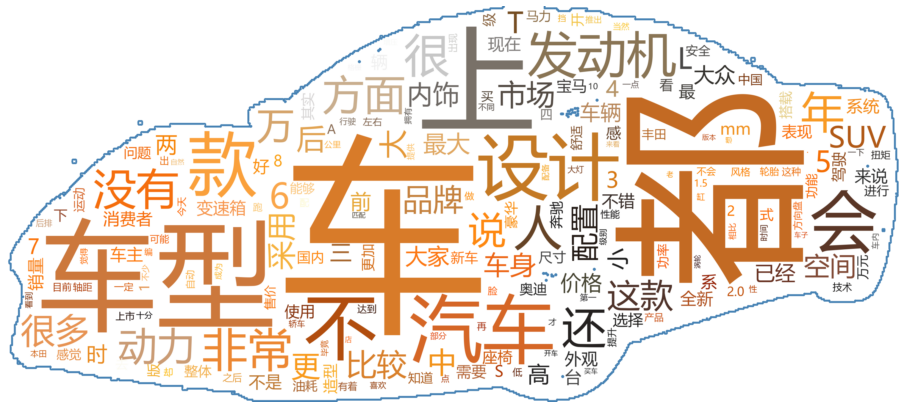

In [152]:
# car
wordcloudplot_fromdict(dict_car,mask=mask_car,stopwords=stopwords)

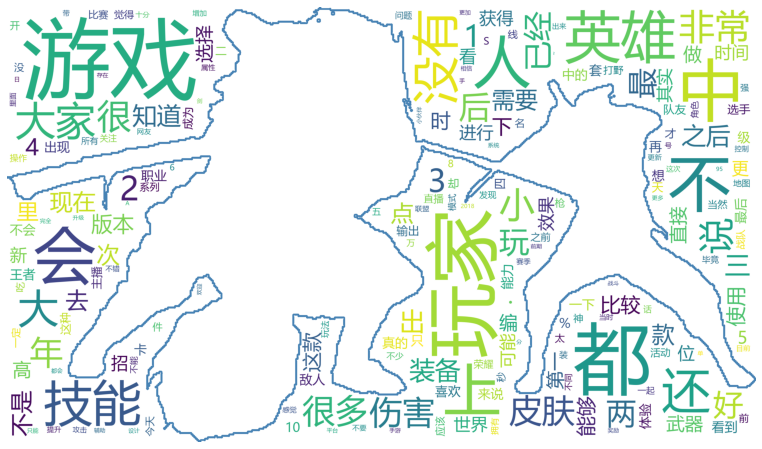

In [153]:
# game
wordcloudplot_fromdict(dict_game,mask=mask_game,stopwords=stopwords)

这里发现如果使用自建的词频字典，停用词会失效，如果使用文本数据可以正常使用。

**注**:从官方文档得到求证 [wordcloud-generate_from_frequencies](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html?highlight=generate_from_frequencies)，确实是这个问题。可通过对字典进行过滤达到同样的效果

## 小结
通过两者方式生成的词云图可以发现，分词结果还是非常不同的。